In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
import os
# Read the CSV file into a DataFrame
df = pd.read_csv('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Updated_p_df.csv')

# 1. Drop the first column `Unnamed: 0`
df.drop(columns=['Unnamed: 0'], inplace=True)

# 2. Convert `Date` column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 3. Function to convert match number (provided in the problem statement)
def convert_match_number(value):
    if value == 'Eliminator':
        return 1001  # Arbitrary unique high number
    elif value == 'Final':
        return 1002  # Arbitrary unique high number
    try:
        return int(value)
    except ValueError:
        return np.nan

# Apply the function and convert to numeric
df['Match Number'] = df['Match Number'].apply(convert_match_number)

# 4. Filter out null `Match Number`
df.dropna(subset = ['Match Number'], inplace=True)
df.isna().sum()

# 1. Create new features
df['Batting_Contribution'] = (df['Player Strike Rate']/100) * df['Player Total Batting Average'] * df['Batsman Prob Score']
df['Bowling_Contribution'] = (df['Player Bowling Average'] * df['Bowler Prob Score']) * ( df['Bowler Aggregated Economy'])

# 2. Update Total_Player_Score
df['Total_Player_Score'] = df['Batting_Contribution'].fillna(0) + df['Bowling_Contribution'].fillna(0)

# 3. Fill missing values with 0
columns_to_fill = ['Player Strike Rate', 'Batsman Prob Score', 'Bowler Aggregated Economy', 'Bowler Prob Score']
for col in columns_to_fill:
    df[col].fillna(0, inplace=True)

# df[['Match Number', 'Season','Gender','Player Team','Player Name','Batting_Contribution', 'Bowling_Contribution']].head(11)


# 4. Calculate team scores with innings filter
team1_scores = df[df['Innings'] == 1].groupby(['Match Number', 'Season', 'Gender', 'Player Team'])['Total_Player_Score'].sum().reset_index()
team2_scores = df[(df['Innings'] == 2) & (df['Team Against'] == df['Player Team'])].groupby(['Match Number', 'Season', 'Gender', 'Team Against'])['Total_Player_Score'].sum().reset_index()

# 5. Rename columns for merging
team1_scores.rename(columns={'Player Team': 'Team1', 'Total_Player_Score': 'Team1_Score'}, inplace=True)
team2_scores.rename(columns={'Team Against': 'Team2', 'Total_Player_Score': 'Team2_Score'}, inplace=True)


# Display the first 5 rows
# print(merged_df.head())
import matplotlib.pyplot as plt

# 12. Plot histograms for Batting_Contribution and Bowling_Contribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Batting_Contribution'], bins=20, color='skyblue', alpha=0.7)
plt.title('Distribution of Batting Contribution')
plt.xlabel('Batting Contribution')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['Bowling_Contribution'], bins=20, color='coral', alpha=0.7)
plt.title('Distribution of Bowling Contribution')
plt.xlabel('Bowling Contribution')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Recalculate team2_scores with correct filtering
# First, create a mapping of Match Number, Season, Gender to Team Against from the first innings
first_innings_teams = df[df['Innings'] == 1][['Match Number', 'Season', 'Gender', 'Team Against']].drop_duplicates()

# Merge this mapping with the second innings data
second_innings_df = pd.merge(df[df['Innings'] == 2], first_innings_teams, on=['Match Number', 'Season', 'Gender'], how='left')

# Filter for rows where Player Team matches the Team Against from the first innings (using Team Against_y)
second_innings_df_filtered = second_innings_df[second_innings_df['Player Team'] == second_innings_df['Team Against_y']]

# Recalculate team2_scores
team2_scores = second_innings_df_filtered.groupby(['Match Number', 'Season', 'Gender', 'Player Team'])['Total_Player_Score'].sum().reset_index()

# Rename columns for merging
team2_scores.rename(columns={'Player Team': 'Team2', 'Total_Player_Score': 'Team2_Score'}, inplace=True)


# Merge the two dataframes
merged_df = pd.merge(team1_scores, team2_scores, on=['Match Number', 'Season', 'Gender'])

# Add target column (Match Winner)
merged_df = pd.merge(merged_df, df[['Match Number', 'Season', 'Gender', 'Match Winner']], on=['Match Number', 'Season', 'Gender'], how='left')

# Merge team stats with the merged dataframe
team_stats = df.groupby(['Season', 'Gender', 'Player Team'])[['Team Avg Score', 'Team Avg Economy', 'Player Team Win %', 'Team Scoring Prob Score', 'Team Economy Prob Score', 'Team Winning % Prob in Season', 'Player Team Probability Score']].mean().reset_index()

merged_df = pd.merge(merged_df, team_stats, left_on=['Season', 'Gender', 'Team1'], right_on=['Season', 'Gender', 'Player Team'], how='left')
merged_df = pd.merge(merged_df, team_stats, left_on=['Season', 'Gender', 'Team2'], right_on=['Season', 'Gender', 'Player Team'], how='left')

# Drop unnecessary columns and rename columns
merged_df.drop(columns=['Player Team_x', 'Player Team_y'], inplace=True)
merged_df.rename(columns={'Team Avg Score_x': 'Team1_Avg_Score',
                          'Team Avg Economy_x': 'Team1_Avg_Economy',
                          'Player Team Win %_x': 'Team1_Win_%',
                          'Team Scoring Prob Score_x': 'Team1_Scoring_Prob_Score',
                          'Team Economy Prob Score_x': 'Team1_Economy_Prob_Score',
                          'Team Winning % Prob in Season_x': 'Team1_Winning_Prob_in_Season',
                          'Player Team Probability Score_x': 'Team1_Probability_Score',
                          'Team Avg Score_y': 'Team2_Avg_Score',
                          'Team Avg Economy_y': 'Team2_Avg_Economy',
                          'Player Team Win %_y': 'Team2_Win_%',
                          'Team Scoring Prob Score_y': 'Team2_Scoring_Prob_Score',
                          'Team Economy Prob Score_y': 'Team2_Economy_Prob_Score',
                          'Team Winning % Prob in Season_y': 'Team2_Winning_Prob_in_Season',
                          'Player Team Probability Score_y': 'Team2_Probability_Score'}, inplace=True)

# Add new features
merged_df['Score_Diff'] = merged_df['Team1_Score'] - merged_df['Team2_Score']
merged_df['Win'] = merged_df.apply(lambda row: 1 if row['Match Winner'] == row['Team1'] else 0, axis=1)

# Print the number of rows in the updated team2_scores
print(f"Number of rows in the updated team2_scores: {len(team2_scores)}")

# Display the first 5 rows
print(merged_df.head())

C:\Users\bhavi\AppData\Local\Temp\ipykernel_15816\2556972539.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)


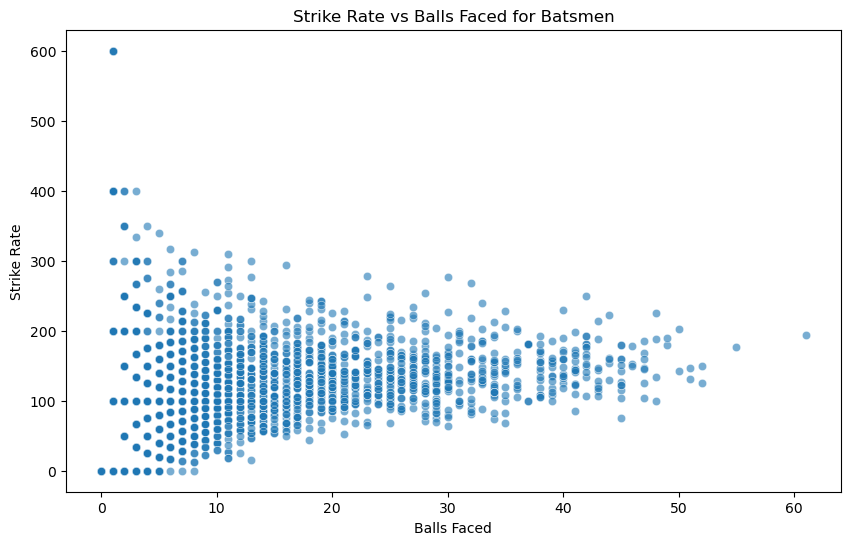

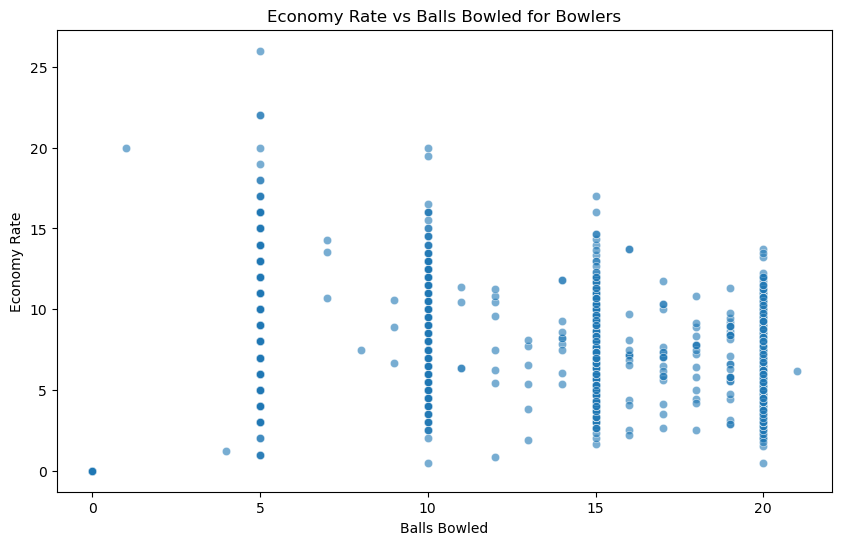

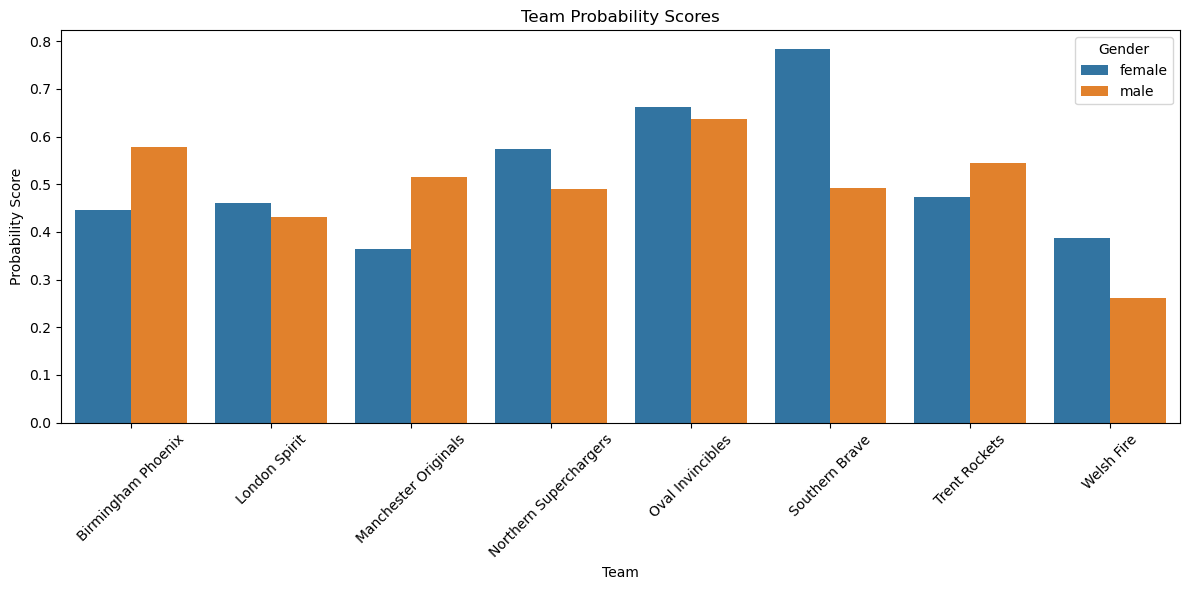

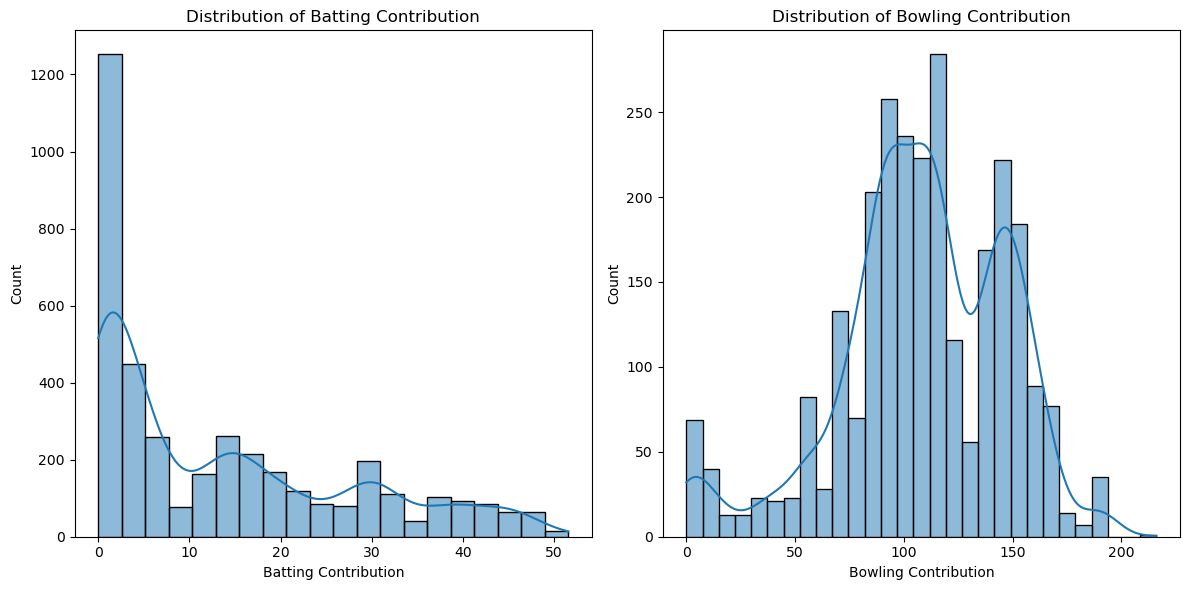

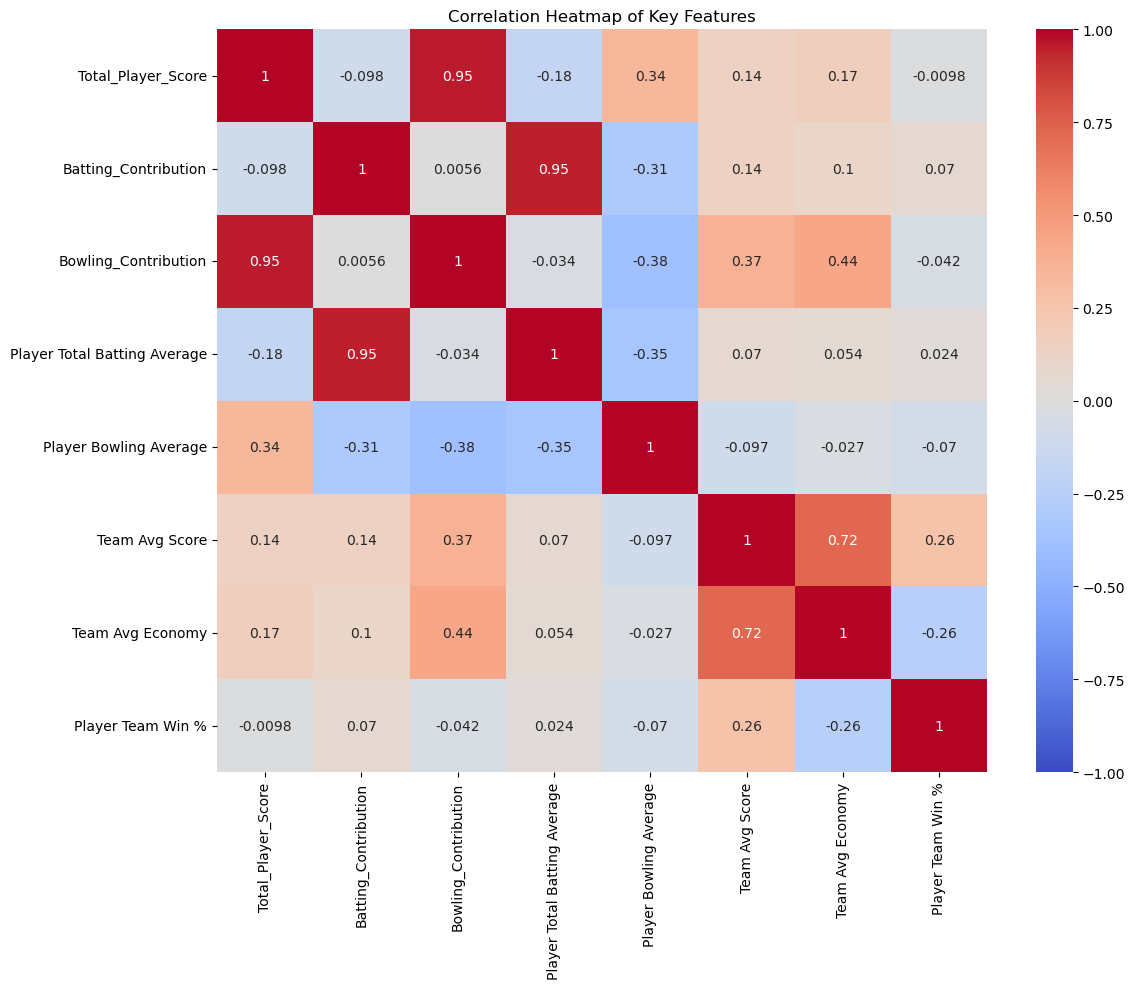

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.inspection import PartialDependenceDisplay
import shap

# Assuming df is your main dataframe and merged_df is the dataframe used for modeling
# If these are not defined, you'll need to load them first

# 1. Scatter plot of Strike Rate vs Balls Faced for batsmen
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Number of Balls Faced', y='Strike Rate', data=df, alpha=0.6)
plt.title('Strike Rate vs Balls Faced for Batsmen')
plt.xlabel('Balls Faced')
plt.ylabel('Strike Rate')
plt.savefig('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Strike Rate vs Balls Faced for Batsmen.png')
plt.show()

# 2. Scatter plot of Economy Rate vs Balls Bowled for bowlers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Number of Balls Bowled', y='Economy', data=df, alpha=0.6)
plt.title('Economy Rate vs Balls Bowled for Bowlers')
plt.xlabel('Balls Bowled')
plt.ylabel('Economy Rate')
plt.savefig('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Economy Rate vs Balls Bowled for Bowlers.png')
plt.show()

# 3. Bar chart of Team Probability Scores
team_prob_scores = df.groupby(['Player Team', 'Gender'])['Player Team Probability Score'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='Player Team', y='Player Team Probability Score', hue='Gender', data=team_prob_scores)
plt.title('Team Probability Scores')
plt.xlabel('Team')
plt.ylabel('Probability Score')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.savefig('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Team Probability Scores.png')
plt.show()




# 9. Distribution of Batting and Bowling Contributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Batting_Contribution'], kde=True)
plt.title('Distribution of Batting Contribution')
plt.xlabel('Batting Contribution')

plt.subplot(1, 2, 2)
sns.histplot(df['Bowling_Contribution'], kde=True)
plt.title('Distribution of Bowling Contribution')
plt.xlabel('Bowling Contribution')

plt.tight_layout()
plt.savefig(f'C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Distribution of Batting & Contribution.png')
plt.show()

# 10. Correlation heatmap of key features
key_features = ['Total_Player_Score', 'Batting_Contribution', 'Bowling_Contribution', 
                'Player Total Batting Average', 'Player Bowling Average', 
                'Team Avg Score', 'Team Avg Economy', 'Player Team Win %']
correlation_matrix = df[key_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Features')
plt.tight_layout()
plt.savefig(f'C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Correlation Heatmap of Key Features.png')
plt.show()

In [17]:
# Model Related Visualizations

In [ ]:
# 4.1 Bar chart comparing model performance metrics
# Assuming you have these metrics calculated
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
rf_scores = [accuracy_rf, precision_rf, recall_rf, f1_rf, auc_rf]  # Replace with actual values
svm_scores = [accuracy_svm, precision_svm, recall_svm, f1_svm, auc_svm]  # Replace with actual values

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, rf_scores, width, label='Random Forest')
rects2 = ax.bar(x + width/2, svm_scores, width, label='SVM')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.tight_layout()
plt.savefig('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Model Performance Comparison.png')
plt.show()

# 4.2 Bar chart comparing model performance metrics
# Assuming you have these metrics calculated
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
rf_scores = [accuracy_best_rf, precision_best_rf, recall_best_rf, f1_best_rf, auc_best_rf]  # Replace with actual values
svm_scores = [accuracy_best_svm, precision_best_svm, recall_best_svm, f1_best_svm, auc_best_svm]  # Replace with actual values

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, rf_scores, width, label='Random Forest')
rects2 = ax.bar(x + width/2, svm_scores, width, label='SVM')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.tight_layout()
plt.savefig('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Model Performance Comparison After Hypertuning.png')
plt.show()

# 5. Bar chart of feature importance scores
feature_importance = rf_model.feature_importances_
feature_names = X.columns

indices = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Top 15 Feature Importances")
plt.bar(range(15), feature_importance[indices][:15])
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=90)
plt.tight_layout()
plt.savefig('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Top 15 Feature Importances.png')
plt.show()

# 6. Partial dependence plot for a key feature
fig, ax = plt.subplots(figsize=(10, 6))
feature = 'Team1_Win_%'  # Replace with an actual feature name
PartialDependenceDisplay.from_estimator(rf_model, X, [feature], ax=ax)

plt.title(f'Partial Dependence Plot for {feature}')
plt.tight_layout()
plt.savefig(f'C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Partial Dependence Plot for {feature}.png')
plt.show()

# 7. SHAP summary plot
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")

# 8. Line graph showing model performance over time
seasons = [2021, 2022, 2023, 2024]
rf_accuracy = [0.75, 0.78, 0.80, 0.82]  # Replace with actual values
svm_accuracy = [0.73, 0.76, 0.79, 0.81]  # Replace with actual values

plt.figure(figsize=(10, 6))
plt.plot(seasons, rf_accuracy, marker='o', label='Random Forest')
plt.plot(seasons, svm_accuracy, marker='s', label='SVM')
plt.title('Model Performance Over Time')
plt.xlabel('Season')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
